## Simulating multi-modal spatial data from dissociated single-cell data

In this tutorial, we will simulate spatial transcriptomics and spatial ATAC data from a single-cell dataset. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from deconvatac.tl import generate_spatial_data
import muon as mu
import scanpy as sc
import pandas as pd

### Load single-cell reference

We will use single-cell data from human heart tissue by [Kanemaru et al](https://doi.org/10.1038/s41586-023-06311-1). The data is available for download on [cellxgene](https://cellxgene.cziscience.com/collections/3116d060-0a8e-4767-99bb-e866badea1ed). 

In [ ]:
mdata = mu.read("./submission_data/data/human_cardiac_niches.h5mu")
mdata 

MuData object with n_obs × n_vars = 139835 × 462560
  var:	'highly_variable'
  2 modalities
    atac:	139835 x 429828
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'
      var:	'highly_variable', 'highly_accessible'
      uns:	'log1p'
      layers:	'log_norm', 'tfidf_normalized'
    rna:	139835 x 32732
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
      var:	'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facility_colors', 'flushed_colors', 'gender_colors', 'hvg', 'kit_10x_colors', 'leiden', 'log1p', 'modality_colors', 'neighbors', 'original_or_new_colors', 'region_colors', 'region_finest_colors', 'scANVI_predictions_colors', 'umap'
      obsm:	'X_scArches', 'X_umap'
      layers:	'log_norm'
      obsp:	'connectivities', 'distances'

### Simulate spatial data

We will simulate two example datasets. In the first dataset, we simulate a homogeneous slide with one zone. The second simulation has four zones, with a different number of cell types in each. 

In [6]:
# Create parameter dictionary
params = {
    "Heart_homogeneous_1zone": {
        "n_regions": 1,
        "cell_type_number": [3],
        "cell_number_nu": [20],
        "cell_number_mean": [5],
        "region_type": "stripes",
        "num_spots": 1000,
        "balance": "balanced",
    },
    "Heart_heterogeneous_4zones": {
        "n_regions": 4,
        "cell_type_number": [10, 5, 7, 3],
        "cell_number_nu": [20, 20, 20, 20],
        "cell_number_mean": [15, 10, 12, 5],
        "region_type": "circles",
        "num_spots": 1000,
        "balance": "balanced",
    }
}

In [ ]:
for key, param in params.items():
    print(key)
    print(param)
    simulation, samples = generate_spatial_data(mdata, cell_type_key="cell_type", **param)
    print(simulation)
    simulation.write(f"./submission_data/example_notebooks/simulation/{key}.h5mu")


Heart_homogeneous_1zone
{'n_regions': 1, 'cell_type_number': [3], 'cell_number_nu': [20], 'cell_number_mean': [5], 'region_type': 'stripes', 'num_spots': 1000, 'balance': 'balanced'}
Region 0: ['Mast cell' 'Mural cell' 'Mesothelial cell'] (mean cells per cluster: 4.485952133194589)
MuData object with n_obs × n_vars = 961 × 462560
  2 modalities
    atac:	961 x 429828
      obs:	'cell_count'
      uns:	'density', 'proportion_names'
      obsm:	'proportions', 'spatial'
    rna:	961 x 32732
      obs:	'cell_count'
      uns:	'density', 'proportion_names'
      obsm:	'proportions', 'spatial'
Heart_heterogeneous_4zones
{'n_regions': 4, 'cell_type_number': [10, 5, 7, 3], 'cell_number_nu': [20, 20, 20, 20], 'cell_number_mean': [15, 10, 12, 5], 'region_type': 'circles', 'num_spots': 1000, 'balance': 'balanced'}
Region 0: ['Mast cell' 'Mural cell' 'Mesothelial cell' 'Lymphoid' 'Neural cell'
 'Ventricular Cardiomyocyte' 'Lymphatic Endothelial cell' 'Fibroblast'
 'Endothelial cell' 'Myeloid'] (me

### Visualize simulated data

In [ ]:
Heart_heterogeneous_4zones = mu.read_h5mu("./example_notebooks/simulation/Heart_heterogeneous_4zones.h5mu")
Heart_homogeneous_1zone = mu.read_h5mu("./example_notebooks/simulation/Heart_homogeneous_1zone.h5mu")

In [15]:
# Save most abundant cell type in each spot to .obs
Heart_heterogeneous_4zones["atac"].obs = Heart_heterogeneous_4zones["atac"].obs.reset_index().join(
    pd.DataFrame(Heart_heterogeneous_4zones["atac"].obsm["proportions"], columns=Heart_heterogeneous_4zones["atac"].uns["proportion_names"]).reset_index(drop=True))
Heart_heterogeneous_4zones['atac'].obs['most_abundant'] = Heart_heterogeneous_4zones["atac"].obs.iloc[:, 2:].idxmax(axis=1)

Heart_homogeneous_1zone["atac"].obs = Heart_homogeneous_1zone["atac"].obs.reset_index().join(
    pd.DataFrame(Heart_homogeneous_1zone["atac"].obsm["proportions"], columns=Heart_homogeneous_1zone["atac"].uns["proportion_names"]).reset_index(drop=True))
Heart_homogeneous_1zone['atac'].obs['most_abundant'] = Heart_homogeneous_1zone["atac"].obs.iloc[:, 2:].idxmax(axis=1)

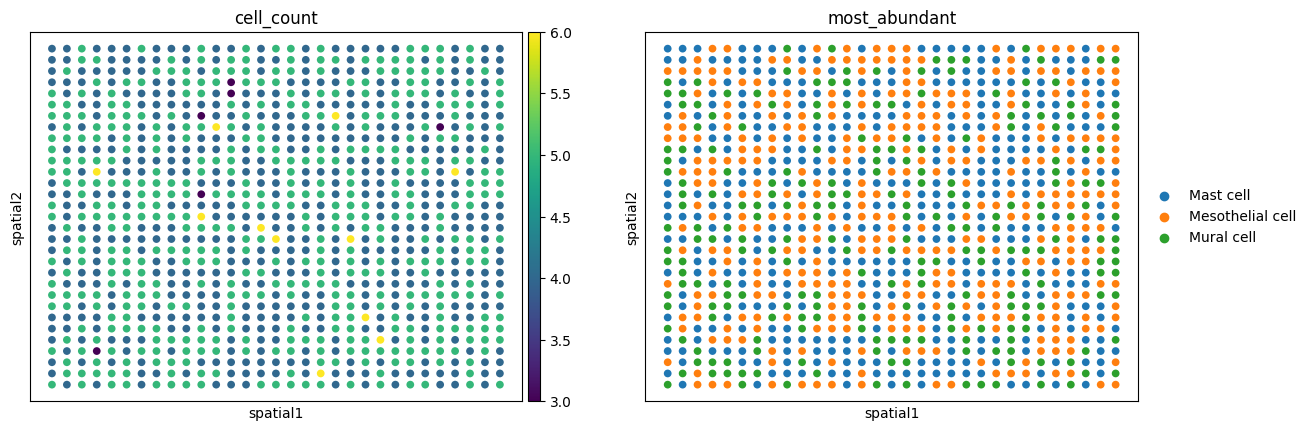

In [19]:
sc.pl.embedding(
    Heart_homogeneous_1zone["atac"],
    basis="spatial",
    color=['cell_count', 'most_abundant'],
)

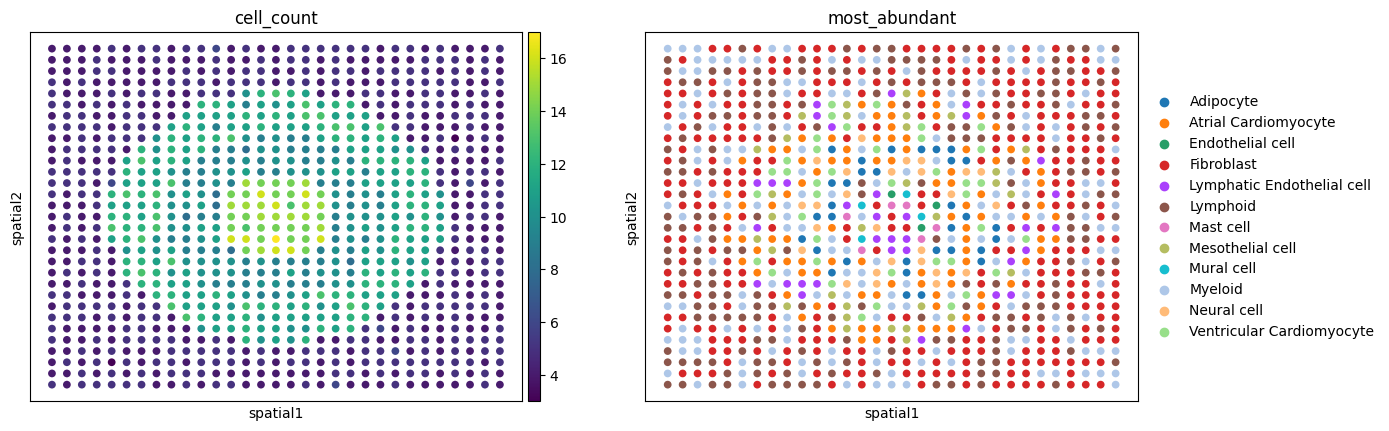

In [17]:
sc.pl.embedding(
    Heart_heterogeneous_4zones["atac"],
    basis="spatial",
    color=['cell_count', 'most_abundant'],
)